In [5]:
!pip install numpy pandas scikit-learn rasterio matplotlib


In [2]:
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import dask.array as da
from dask.diagnostics import ProgressBar
from shapely import wkt
import geopandas as gpd
from rasterstats import zonal_stats


In [45]:
import geopandas as gpd

df = pd.read_csv(r"C:\Users\kalmanj\Documents\SCHOOL\695\Final\bufferdatasf.csv")
philly['geometry'] = philly['geometry.x'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry="geometry")
gdf = gdf.set_crs("EPSG:4269", inplace=True)

In [46]:
with rasterio.open(r"C:\Users\kalmanj\Documents\SCHOOL\695\Final\maskphily-naip.tif") as src:
    naip_crs = src.crs

gdf = gdf.to_crs(naip_crs)

In [50]:
with rasterio.open(r"C:\Users\kalmanj\Documents\SCHOOL\695\Final\maskphily-naip.tif") as src:
    R = src.read(1).astype('float32')  # Red band
    G = src.read(2).astype('float32')  # Green band
    B = src.read(3).astype('float32')  # Blue band
    profile = src.profile
    bsi = (R + G - B) / (R + G + B + 1e-6)


In [62]:
import rasterio
import numpy as np

# Open the original file to get the profile (metadata)
with rasterio.open(r"C:\Users\kalmanj\Documents\SCHOOL\695\Final\maskPhily-naip.tif") as src:
    profile = src.profile
    nodata_value = src.nodata  # Get the NoData value from the source file
    profile.update(dtype=rasterio.float32, count=1, nodata=nodata_value)  # Ensure correct data type

    # Save the BSI data to a new file
    with rasterio.open("bsi_index.tif", 'w', **profile) as dst:
        dst.write(bsi, 1)  # Write the BSI data to the first band


BSI min/max values: -0.0726817 0.61612284


In [63]:
stats = zonal_stats(gdf, "bsi_index.tif", stats=["mean"], geojson_out=True)
heat_means = [feat["properties"]["mean"] for feat in stats]
gdf["heat_coverage"] = heat_means

In [64]:
heat_grouped = gdf.groupby("geocode")["heat_coverage"].mean()
print("Average heat index:")
print(heat_grouped)
heat_grouped = heat_grouped.reset_index()

Average heat index:
geocode
42101000101    0.318909
42101000102    0.325600
42101000200    0.321175
42101000300    0.318940
42101000401    0.310813
                 ...   
42101980905    0.335357
42101980906    0.339384
42101989100    0.310554
42101989200    0.317602
42101989300    0.391401
Name: heat_coverage, Length: 408, dtype: float64


In [83]:
heat_merged = df.merge(heat_grouped[['geocode', 'heat_coverage']], on='geocode', how='left')
heat_means = gdf.groupby("bufferzone")["heat_coverage"].mean()
print(heat_means)

print(gdf.groupby("bufferzone")["heat_coverage"].std())

bufferzone
Inside     0.345582
Outside    0.353954
Name: heat_coverage, dtype: float64
bufferzone
Inside     0.026364
Outside    0.024252
Name: heat_coverage, dtype: float64


In [66]:
print(heat_merged)


         geocode bufferzone  como.rate  \
0    42101039100     Inside   0.000000   
1    42101980902     Inside   0.000000   
2    42101980904    Outside   0.000000   
3    42101980903     Inside   0.000000   
4    42101980906    Outside   0.000000   
..           ...        ...        ...   
403  42101013602    Outside   0.143333   
404  42101034502    Outside   0.279412   
405  42101000902     Inside   0.225490   
406  42101001201     Inside   0.132701   
407  42101002702     Inside   0.198238   

                                              geometry  heat_coverage  
0    MULTIPOLYGON (((-75.22235 39.93105, -75.22129 ...       0.334663  
1    MULTIPOLYGON (((-75.20684 39.93409, -75.20655 ...       0.325128  
2    MULTIPOLYGON (((-75.21243 39.92523, -75.2113 3...       0.350612  
3    MULTIPOLYGON (((-75.20422 39.93285, -75.20305 ...       0.343371  
4    MULTIPOLYGON (((-75.21612 39.90964, -75.21454 ...       0.339384  
..                                                 ...         

In [81]:
bufferzone_statsheat = heat_merged.groupby('bufferzone')['heat_coverage'].agg(['max', 'min']).reset_index()
bufferzone_statsheat['max_heat_coverage'] = bufferzone_statsheat['max']
bufferzone_statsheat['min_heat_coverage'] = bufferzone_statsheat['min']
print(bufferzone_statsheat)


  bufferzone       max       min  max_heat_coverage  min_heat_coverage
0     Inside  0.430860  0.294349           0.430860           0.294349
1    Outside  0.419547  0.267407           0.419547           0.267407


AttributeError: 'SeriesGroupBy' object has no attribute 'sd'

In [68]:
bar_colors={'Inside': '#f8ff91', 'Outside': '#df4e00'}

C:\Users\kalmanj\AppData\Local\Temp\ipykernel_25388\785539325.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x='bufferzone', y='heat_coverage', data=heat_merged, palette=bar_colors)


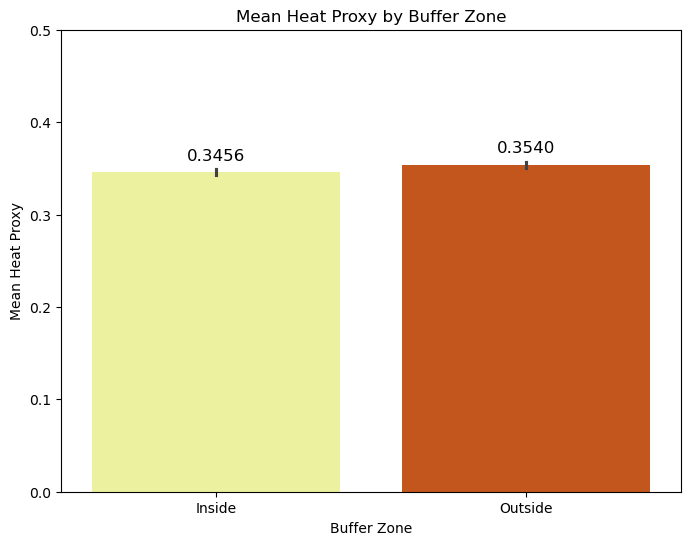

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # Set figure size
ax=sns.barplot(x='bufferzone', y='heat_coverage', data=heat_merged, palette=bar_colors)

# Add labels and title
plt.xlabel('Buffer Zone')
plt.ylabel('Mean Heat Proxy')
plt.title('Mean Heat Proxy by Buffer Zone')
for p in ax.patches:  # Loop through the bars (patches)
    height = p.get_height()  # Get the height (value) of each bar
    ax.text(p.get_x() + p.get_width() / 2., height+0.01,  # Position the text
            f'{height:.4f}',  # Format the text to 2 decimal places
            ha="center", va="bottom", fontsize=12)  # Adjust the alignment and font size
plt.ylim(0,0.5)
plt.show()

In [86]:
mu = heat_merged["heat_coverage"].mean()
sigma = heat_merged["heat_coverage"].std()
heat_merged["heat_cat"] = pd.cut(
    heat_merged["heat_coverage"],
    bins=[-np.inf, mu - sigma, mu + sigma, np.inf],
    labels=["Low", "Medium", "High"]
)
min_val = heat_merged['heat_coverage'].min()
max_val = heat_merged['heat_coverage'].max()


# Define thresholds
low_thresh = mu - sigma
high_thresh = mu + sigma

# Build a lookup table
lookup = pd.DataFrame({
    "Category": ["Low", "Medium", "High"],
    "Range": [
        f'[{min_val:.3f}, {low_thresh:.3f})',
        f'[{low_thresh:.3f}, {high_thresh:.3f})',
        f'[{high_thresh:.3f}, {max_val:.3f}]'
    ]
})

print(lookup.to_string(index=False))


Category          Range
     Low [0.267, 0.324)
  Medium [0.324, 0.375)
    High [0.375, 0.431]


In [87]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

fhcs = pd.read_csv(r"C:\Users\kalmanj\Documents\SCHOOL\695\Final\fqhcsphilly.csv")  # must have e.g. 'lon' & 'lat' columns
geometry = [Point(xy) for xy in zip(fhcs.lon, fhcs.lat)]
fhcs = gpd.GeoDataFrame(fhcs, geometry=geometry)
fhcs = fhcs.set_crs("EPSG:4269", inplace=False)
heat_merged = gpd.GeoDataFrame(heat_merged, geometry='geometry')
heat_merged= heat_merged.set_crs("EPSG:4269", inplace=False)
heat_merged = heat_merged.to_crs(fhcs.crs)

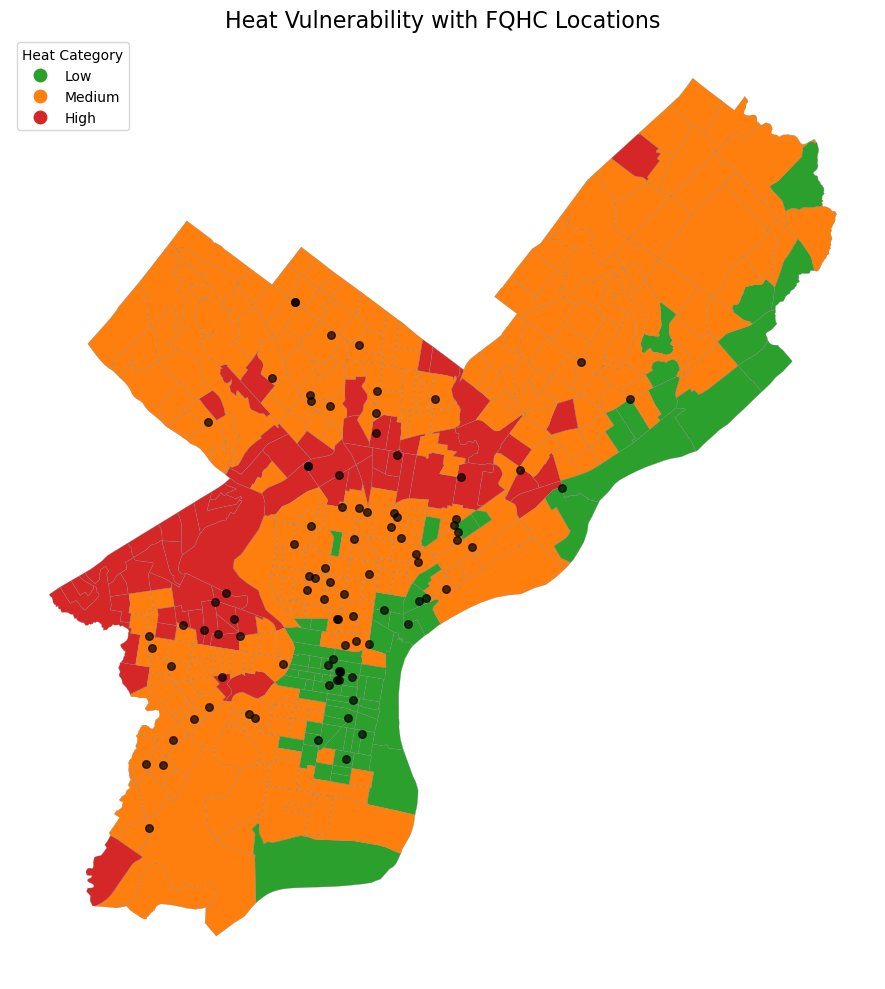

In [88]:
from matplotlib.colors import ListedColormap
if not isinstance(heat_merged, gpd.GeoDataFrame):
    heat_merged = gpd.GeoDataFrame(heat_merged, geometry="geometry")
cmap = ListedColormap(['#2ca02c', '#ff7f0e', '#d62728'])  

# 4. Plot with automatic legend
fig, ax = plt.subplots(figsize=(10,10))
heat_merged.plot(
    column='heat_cat',
    cmap=cmap,
    legend=True,
    categorical=True,
    legend_kwds={'loc': 'upper left', 'title': 'Heat Category'},
    linewidth=0.2,
    edgecolor='gray',
    ax=ax
)
fhcs.plot(
    ax=ax,
    marker='o',
    color='black',
    markersize=30,
    alpha=0.7,
    label='Health Locations'    # change label as appropriate
)
ax.set_title('Heat Vulnerability with FQHC Locations', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


In [73]:
pts_with_cat = gpd.sjoin(
    fhcs,
    heat_merged[['heat_cat', 'geometry']],
    how='left',
    predicate='within'
)

# 3. Count points per category
counts = (
    pts_with_cat
    .groupby('heat_cat')
    .size()
    .reindex(['Low','Medium','High'], fill_value=0)
    .rename('point_count')
    .reset_index()
)

print(counts)

  heat_cat  point_count
0      Low           19
1   Medium           59
2     High           14


C:\Users\kalmanj\AppData\Local\Temp\ipykernel_25388\3111357951.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('heat_cat')


In [74]:
# Save
# Make a copy to avoid changing the original
heat_fixed = heat_merged.copy()

# Convert all categorical columns to strings
for col in heat_fixed.select_dtypes(include='category').columns:
    heat_fixed[col] = heat_fixed[col].astype(str)

# Now save safely
heat_fixed.to_file("heat_data.gpkg", layer="heat", driver="GPKG")


